<a href="https://colab.research.google.com/github/EasyLion05/Neural-Network-SMS-Text-Classifier/blob/main/Copy_of_fcc_sms_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -N https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget -N https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv


--2022-10-27 18:41:33--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘train-data.tsv’ not modified on server. Omitting download.

--2022-10-27 18:41:33--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘valid-data.tsv’ not modified on server. Omitting download.



In [ ]:
!pip install tensorflow-datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Import libraries
import tensorflow as tf
import pandas as pd
from tensorflow import keras
# import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence


In [ ]:
#Train data frame

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

train_df = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])
train_df.dropna()
train_df.head()

,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [ ]:
# gTest data frame

test_df = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])
test_df.dropna()
train_df.head()

,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [ ]:
#Prepare labels for training

train_df["type"] = pd.factorize(train_df["type"])[0]
test_df["type"] = pd.factorize(test_df["type"])[0]

In [ ]:
train_df.head()

,type,msg
0,0,i am in hospital da. . i will return home in e...
1,0,"not much, just some textin'. how bout you?"
2,0,i probably won't eat at all today. i think i'm...
3,0,don‘t give a flying monkeys wot they think and...
4,0,who are you seeing?


In [ ]:
train_labels =  train_df["type"].values
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df["msg"].values, train_labels)
)

In [ ]:
test_labels =  test_df["type"].values
test_ds = tf.data.Dataset.from_tensor_slices(
    (test_df["msg"].values, test_labels)
)
test_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
# This step is important. It's not only about batching the data sets, but also reshape it to make it works when fitting the model. Otherwise, we will get incompatible layers errors: expecting ndim=3, got ndim=2.
BUFFER_SIZE = 100
BATCH_SIZE = 32
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
#Creating a TextVectorization layer for our model

vec = TextVectorization(
    output_mode='int',
    max_tokens=1000,
    output_sequence_length=1000,
)

vec.adapt(train_ds.map(lambda text, label: text))

In [ ]:
#Let's show the vocabulary that our vectorizer has learned.

vocab = np.array(vec.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'i', 'to', 'you', 'a', 'the', 'u', 'and', 'is', 'in',
       'me', 'my', 'your', 'for', 'have', 'it', 'of', 'call', 'that'],
      dtype='<U16')

In [ ]:
#Create the model

model = tf.keras.Sequential([
    vec,
    tf.keras.layers.Embedding(
        len(vec.get_vocabulary()),
        64,
        mask_zero=True,
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])


model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy'],
)

In [ ]:
#Training the model against our data sets.

history = model.fit(
    train_ds,
    validation_data=test_ds,
    validation_steps=30,
    epochs=10,
)

Epoch 1/10
44/44 [==============================] - 188s 4s/step - loss: 0.6778 - accuracy: 0.8657 - val_loss: 0.6544 - val_accuracy: 0.8604
Epoch 2/10
44/44 [==============================] - 148s 3s/step - loss: 0.6053 - accuracy: 0.8657 - val_loss: 0.5492 - val_accuracy: 0.8604
Epoch 3/10
44/44 [==============================] - 149s 3s/step - loss: 0.5070 - accuracy: 0.8657 - val_loss: 0.4772 - val_accuracy: 0.8604
Epoch 4/10
44/44 [==============================] - 150s 3s/step - loss: 0.4324 - accuracy: 0.8657 - val_loss: 0.3906 - val_accuracy: 0.8604
Epoch 5/10
44/44 [==============================] - 150s 3s/step - loss: 0.3248 - accuracy: 0.8657 - val_loss: 0.2530 - val_accuracy: 0.8604
Epoch 6/10
44/44 [==============================] - 147s 3s/step - loss: 0.2009 - accuracy: 0.8757 - val_loss: 0.1520 - val_accuracy: 0.9302
Epoch 7/10
44/44 [==============================] - 147s 3s/step - loss: 0.1219 - accuracy: 0.9634 - val_loss: 0.0900 - val_accuracy: 0.9833
Epoch 8/10
44

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)

44/44 [==============================] - 26s 581ms/step - loss: 0.0404 - accuracy: 0.9914


In [ ]:
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Test Loss: 0.040370143949985504
Test Accuracy: 0.9913793206214905


Plot the accuracy and loss metrics

In [ ]:
#Create a helper function to plot

def plot_graphs(h, metric):
    plt.plot(h.history[metric])
    plt.plot(h.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

(0.0, 0.7094547791406512)

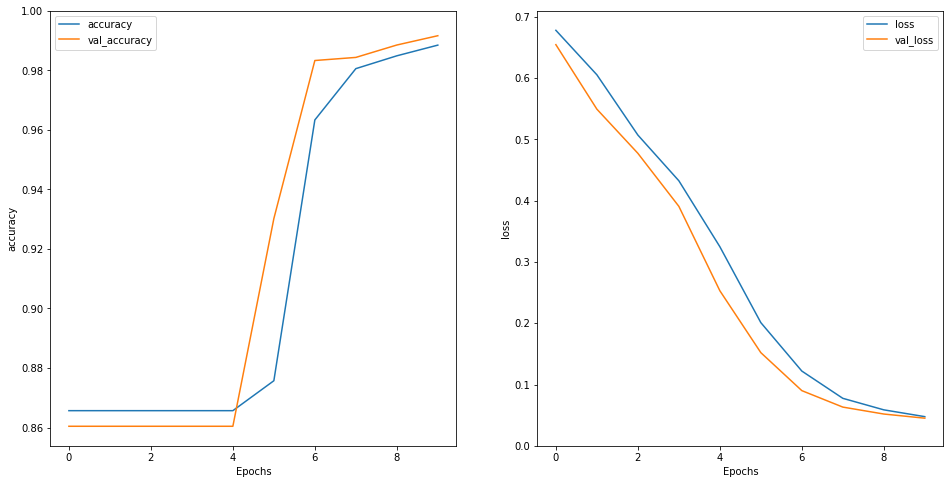

In [ ]:
#Plot the graphs

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
h = history.history
print(h['loss'])
print(h['val_loss'])
print(h['accuracy'])
print(h['val_accuracy'])

[0.6778160929679871, 0.6052812933921814, 0.5069683790206909, 0.432378888130188, 0.3248228430747986, 0.20092666149139404, 0.1219235211610794, 0.07743773609399796, 0.05866272747516632, 0.047551482915878296]
[0.654399037361145, 0.5491956472396851, 0.47718730568885803, 0.390643447637558, 0.2529805302619934, 0.15195675194263458, 0.08999288082122803, 0.06314648687839508, 0.051822759211063385, 0.04504236951470375]
[0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8757184147834778, 0.9633620977401733, 0.9806034564971924, 0.9849137663841248, 0.9885057210922241]
[0.8604166507720947, 0.8604166507720947, 0.8604166507720947, 0.8604166507720947, 0.8604166507720947, 0.9302083253860474, 0.9833333492279053, 0.984375, 0.9885416626930237, 0.9916666746139526]


In [ ]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
    ps = model.predict([pred_text])
    print(ps)
    p = ps[0][0]
    return [p, "ham" if p <0.5 else "spam"]

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

1/1 [==============================] - 7s 7s/step
[[-4.977053]]
[-4.977053, 'ham']


In [ ]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460 4",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 [==============================] - 0s 268ms/step
[[-4.977053]]
1/1 [==============================] - 0s 343ms/step
[[0.66083336]]
1/1 [==============================] - 0s 268ms/step
[[-10.741521]]
1/1 [==============================] - 0s 267ms/step
[[1.0980753]]
1/1 [==============================] - 0s 266ms/step
[[2.232028]]
1/1 [==============================] - 0s 264ms/step
[[-9.174245]]
1/1 [==============================] - 0s 292ms/step
[[-8.985027]]
You passed the challenge. Great job!
